In [1]:
# import libraries
import pandas as pd
import numpy as np
from label_functions import *
from functions import *
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.tree import plot_tree

# import data
event_log = import_xes("data/Hospital_log.xes.gz")

parsing log, completed traces ::   0%|          | 0/1143 [00:00<?, ?it/s]

In [ ]:
def on_the_fly_model(prefix_max_len=21,
                     prefix_steps=5,
                     n_most_similar=100,
                     X_cols=['case:Diagnosis code', 'case:Treatment code'],
                     lf=label_function_1,
                     n_validation='all',
                     get_clf_index=None):
    '''
    Train the on-the-fly model with leave-one-out cross-validation.

    Parameters:
    prefix_max_len: Maximum length of the prefix.
    prefix_steps:   Number of steps to take between prefixes.
    n_most_similar: Number of most similar traces to consider.
    X_cols:         Columns to use as features.
    lf:             Which label function to use.
    n_validation:   Number of traces to validate.
                    'all' to validate all prefixes of all traces.
    get_clf_index:  returns the DecisionTreeClassifier of the index given.
                    None allows the function to run normally.
    
    Returns dataframe with prediction results.
    '''

    # get all traces
    all_traces = event_log.groupby('case:concept:name')['Activity code']\
                          .apply(list)

    # extract prefixes
    all_traces = all_traces.apply(lambda x: prefix_extraction(x,
                                                              prefix_max_len,
                                                              prefix_steps))
    all_traces = all_traces.explode()

    # get a label function map
    lf_map = get_lf_map(event_log, lf)

    # set n_validation to all if needed
    if n_validation == 'all':
        n_validation = len(all_traces)
    else:
        n_validation = min(n_validation, len(all_traces))
        all_traces = all_traces.sample(n_validation)

    # Train model with leave-one-out cross-validation
    df_predictions = []
    for i in range(n_validation):
        running_trace = all_traces.iloc[[i]]
        # Drop all prefixes of running trace
        historic_traces = all_traces.drop(running_trace.index)

        running_trace_length = len(running_trace.iloc[0])

        # calculate similarity scores
        similarity_scores = get_similarity(running_trace,
                                           historic_traces,
                                           similarity=True)

        # get n most similar traces
        sorted_similar_traces = sorted(similarity_scores.items(),
                                       key=lambda x: x[1],
                                       reverse=True)
        most_similar_traces = sorted_similar_traces[:n_most_similar]

        # calculate average similarity score
        avg_similarity = np.mean([x[1] for x in most_similar_traces])

        # get label function
        similar_traces_list = [x[0] for x in most_similar_traces]

        # get y_train and y_test
        y_train = [lf_map[trace] for trace in similar_traces_list]
        y_test = int(lf_map[running_trace.index[0]])

        # train model
        clf, le_dict = train_model(X_cols,
                                   event_log,
                                   similar_traces_list,
                                   lf_map)

        # return clf on first instance
        if get_clf_index != None and i == get_clf_index:
            return clf

        # predict label
        y_pred, y_prob = predict_label(X_cols,
                                       event_log,
                                       running_trace,
                                       clf,
                                       le_dict)

        # add prediction data to df_predictions
        results = [running_trace_length, avg_similarity, sum(y_train),
                   y_test, y_pred, y_prob]
        df_predictions.append(results)

    # convert df_predictions to a DataFrame
    col_names = ['trace_len', 'avg_similarity', 'pos_y_train',
                 'y_test', 'y_pred', 'y_prob']
    df_predictions = pd.DataFrame(df_predictions, columns=col_names)

    # accuracy from most common label
    acc1 = max(lf_map.mean(), 1-lf_map.mean())

    # accuracy from most common label among similar traces
    acc2 = ((df_predictions['pos_y_train'] > n_most_similar/2)
            == df_predictions['y_test']).mean()

    # accuracy from decision tree model
    acc3 = (df_predictions['y_test'] == df_predictions['y_pred']).mean()

    # print accuracies
    print(f'n={n_most_similar}')
    print(f'Accuracy from most common label: {acc1:.3f}')
    print(f'Accuracy from most common label among similar traces: {acc2:.3f}')
    print(f'Accuracy from decision tree model: {acc3:.3f} \n')

    return df_predictions


def get_metrics(df_predictions, failure_threshold=0.6):
    '''
    Get metrics from model predictions.

    Parameters:
    df_predictions:     DataFrame with prediction results.
    failure_threshold:  If the class probability from the decision tree
                        is below this threshold, the prediction is considered
                        a failure.

    Returns failure rate, accuracy and f1 score.
    '''

    df_predictions['correct'] = df_predictions['y_test'] == df_predictions['y_pred']
    df_predictions['failure'] = df_predictions['y_prob'] < failure_threshold
    failure_rate = df_predictions['failure'].mean()

    df_success_predictions = df_predictions[~df_predictions['failure']]
    accuracy = df_success_predictions['correct'].mean()
    f1 = f1_score(df_success_predictions['y_test'],
                  df_success_predictions['y_pred'])

    return failure_rate, accuracy, f1

In [ ]:
# Run model with different n_most_similar values

# set parameters
df_results = []
metric_results = []
n_validation = 'all'  # number of validation runs (LOOCV)
n_most_similar_values = [10, 50, 100, 200, 300]

# run model iteratively
for n_most_similar in n_most_similar_values:
    # run model
    df_predictions = on_the_fly_model(n_most_similar=n_most_similar,
                                      n_validation=n_validation)
    # save results
    df_results.append(df_predictions)
    failure_rate, accuracy, f1 = get_metrics(df_predictions)
    metric_results.append([n_most_similar, failure_rate, accuracy, f1])

# convert results to a DataFrame
col_names = ['n_most_similar', 'failure_rate', 'accuracy', 'f1']
results = pd.DataFrame(metric_results, columns=col_names)

n=10
Accuracy from most common label: 0.598
Accuracy from most common label among similar traces: 0.659
Accuracy from decision tree model: 0.656 

n=50
Accuracy from most common label: 0.598
Accuracy from most common label among similar traces: 0.647
Accuracy from decision tree model: 0.675 

n=100
Accuracy from most common label: 0.598
Accuracy from most common label among similar traces: 0.632
Accuracy from decision tree model: 0.683 

n=200
Accuracy from most common label: 0.598
Accuracy from most common label among similar traces: 0.652
Accuracy from decision tree model: 0.673 

n=300
Accuracy from most common label: 0.598
Accuracy from most common label among similar traces: 0.640
Accuracy from decision tree model: 0.677 



In [21]:
# load results (instead of running the model)
results = pd.read_csv('data/on_the_fly_results.csv')
results

,n_most_similar,failure_rate,accuracy,f1
0,10,0.164474,0.674179,0.700897
1,50,0.203721,0.705983,0.732365
2,100,0.252495,0.717147,0.721458
3,200,0.374093,0.756433,0.763214
4,300,0.382713,0.768835,0.776713


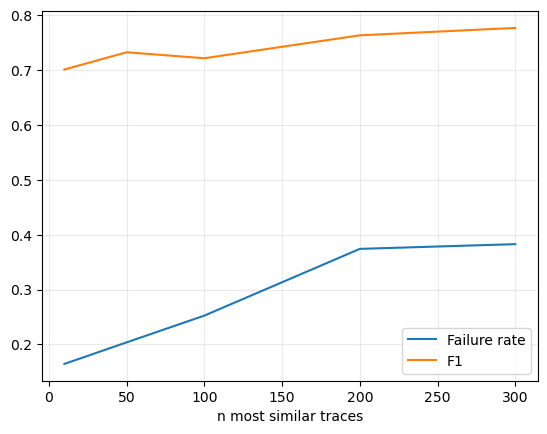

In [22]:
# plot metrics per n_most_similar
plt.plot(results['n_most_similar'],
         results['failure_rate'],
         label='Failure rate')
plt.plot(results['n_most_similar'],
         results['f1'],
         label='F1')

plt.xlabel('n most similar traces')
plt.legend()
plt.grid(alpha=0.25)

In [ ]:
# run model with all best parameters
df_predictions = on_the_fly_model(n_most_similar=50,
                                  n_validation='all')
failure_rate, accuracy, f1 = get_metrics(df_predictions)

n=50
Accuracy from most common label: 0.598
Accuracy from most common label among similar traces: 0.647
Accuracy from decision tree model: 0.675 



In [9]:
# print metrics
print(f'Failure rate: {failure_rate:.3f}')
print(f'Accuracy: {accuracy:.3f}')
print(f'F1: {f1:.3f}')

Failure rate: 0.204
Accuracy: 0.706
F1: 0.732


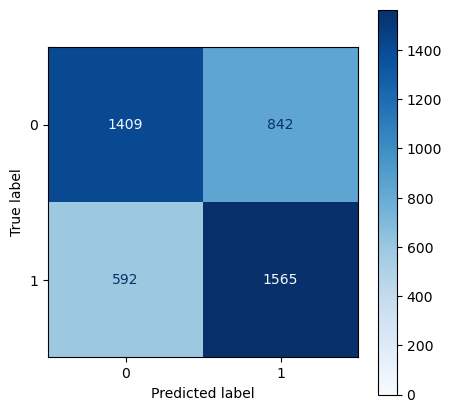

In [ ]:
# confusion matrix figure
cm = confusion_matrix(df_predictions['y_test'],
                      df_predictions['y_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0', '1'])
disp.plot(cmap='Blues')

# decrease figure size
plt.gcf().set_size_inches(5, 5)
disp.ax_.get_images()[0].set_clim(0, cm.max())

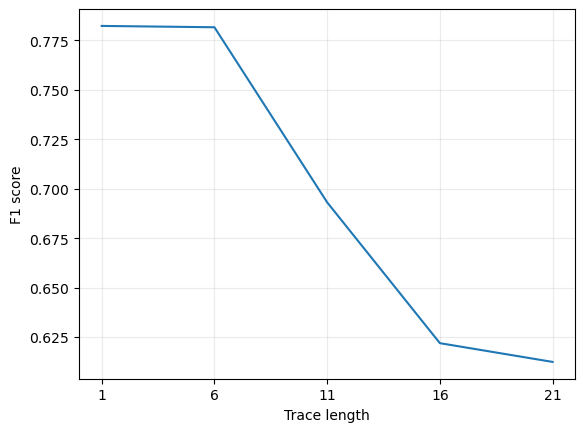

In [ ]:
# compute f1 score per trace length
f1_scores = []
df_success_preds = df_predictions[~df_predictions['failure']].copy()
for trace_len in sorted(df_success_preds['trace_len'].unique()):
    df_trace_len = df_success_preds[df_success_preds['trace_len'] == trace_len]
    f1 = f1_score(df_trace_len['y_test'], df_trace_len['y_pred'])
    f1_scores.append([trace_len, f1])
f1_scores = pd.DataFrame(f1_scores, columns=['trace_len', 'f1'])

# plot f1 score per trace length
plt.plot(f1_scores['trace_len'], f1_scores['f1'])
plt.xlabel('Trace length')
plt.ylabel('F1 score')
plt.grid(alpha=0.25)
plt.xticks(np.arange(1, 22, 5))

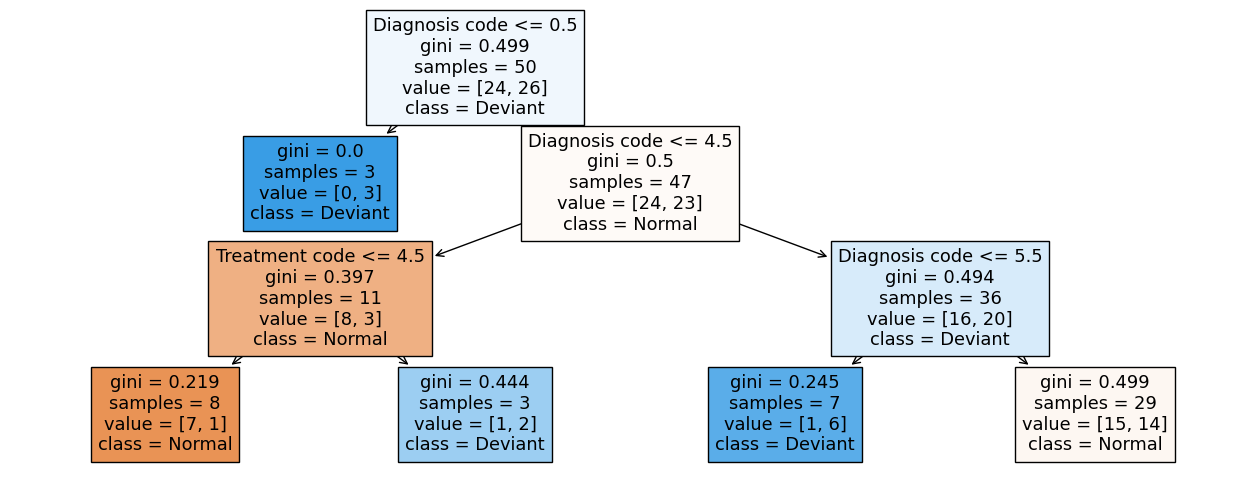

In [ ]:
# plot a decision tree
clf = on_the_fly_model(n_most_similar=50,
                       get_clf_index=5)

plt.figure(figsize=(16, 6))
plot_tree(clf,
          feature_names=['Diagnosis code', 'Treatment code'],
          filled=True,
          class_names=['Normal', 'Deviant'])

### Visualizations

In [ ]:
# get all traces
all_traces = event_log.groupby('case:concept:name')['Activity code']\
    .apply(list)

# extract prefixes
all_traces = all_traces.apply(lambda x: prefix_extraction(x,
                                                          max_len=21,
                                                          steps=5))
all_traces = all_traces.explode()

# evaluate similarity thresholds by the amount of traces it includes
df_list = []
for th in np.arange(0, 1.1, 0.1):
    n_similar_traces = []
    for _ in range(250):
        running_trace = all_traces.sample(1)
        historic_traces = all_traces.drop(running_trace.index)
        similar_traces = get_similarity(
            running_trace, historic_traces, similarity=True)
        similar_traces = {k: v for k, v in similar_traces.items() if v > th}
        n_similar_traces.append(len(similar_traces))
    mean_similar_traces = sum(n_similar_traces) / len(n_similar_traces)
    min_similar_traces = min(n_similar_traces)
    df_list.append([th, mean_similar_traces, min_similar_traces])

df_th = pd.DataFrame(df_list,
                     columns=['Threshold', 'Mean similar traces', 'Min similar traces'])

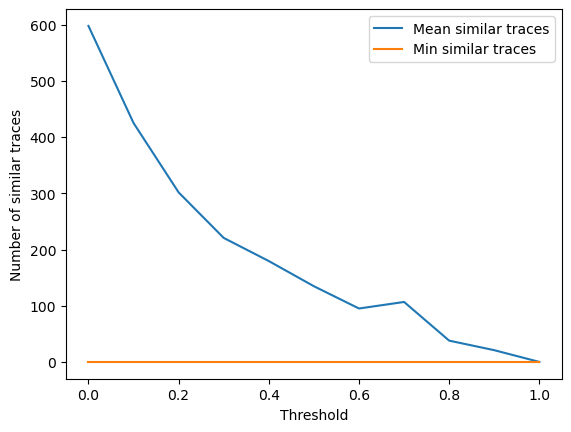

In [ ]:
# plot similarity threshold and number of similar traces
plt.plot(df_th['Threshold'], df_th['Mean similar traces'],
         label='Mean similar traces')
plt.plot(df_th['Threshold'], df_th['Min similar traces'],
         label='Min similar traces')
plt.xlabel('Threshold')
plt.ylabel('Number of similar traces')
plt.legend()